# GAIA PSF Simulation

First attempt to simulate close binary stars observation using the gaia telescope. The latter is imagined as a rectangular pupil, with no pixel binning or aberrations

#### Initialization

In [30]:
# %matplotlib qt
import logging
# logging.basicConfig(level=logging.WARNING, format=' - %(levelname)s - %(message)s')

In [31]:
import functools
import time

def timer(func):
    """Decorator to time the execution of a function."""

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        h = (end_time - start_time) // 3600
        m = (end_time - start_time) % 3600 // 60
        s = (end_time - start_time) % 60
        print(f"Execution time: {int(h):02d}:{int(m):02d}:{s:.2f} (h:m:s)")
        return result

    return wrapper

In [32]:
import poppy
import xupy as xp
from xupy import typing as xt
import astropy.units as u
from astropy import convolution as c
from astropy.io import fits
from astropy.table import QTable
from matplotlib import pyplot as plt
from simulator import BinarySystem, CCD
import utils as osu

Gpb = QTable.read("data/gaiaDR3passband.fits")
weights = Gpb.filled(0)

def rebinned(psf: fits.HDUList | xt.ArrayLike, rebin_factor: int) -> fits.HDUList:
    """
    Rebin PSF by a given factor, following Gaia's pixel scale (1:3 ratio).
    """
    if isinstance(psf, fits.HDUList):
        psf = psf[0].data
    px_ratio = (rebin_factor, 3*rebin_factor)
    return poppy.utils.rebin_array(psf, px_ratio)

```py
poppy.conf.use_multiprocessing = False
poppy.conf.n_processes = 20
poppy.conf.double_precision = False

M1 = poppy.RectangleAperture(name="Primary Mirror", height=1.45*u.m, width=0.5*u.m)
M2 = poppy.RectangleAperture(name="Beam Collimator / Secondary Mirror",width=0.35*u.m, height=0.2*u.m)
telescope = poppy.OpticalSystem(name="Gaia", oversample=1, verbose=True)

telescope.add_pupil(M1)
telescope.add_detector(name="SkyPLANE", pixelscale=0.001*(u.arcsec/u.pixel), fov_pixels=1125, oversample=4)

psf = telescope.calc_psf(progressbar=True, return_final=True, source={'wavelengths': Gpb['lambda'], 'weights': weights['G']})

poppy.utils.display_psf(psf[0], title="Gaia PSF", vmax=psf[0][0].data.max())
psf[0].writeto("data/simulations/PSFs/20250922_2_gaia_psf.fits", overwrite=True)

## Got The PSF: Now on to the convolution

#### Creating the **Binary Star System (BSS)** and the **CCD**

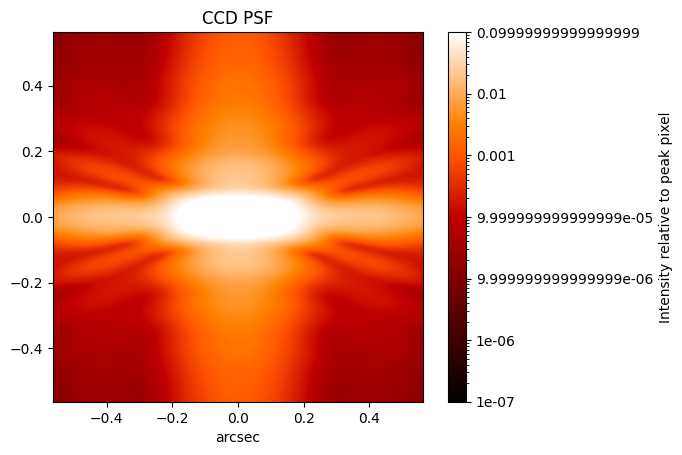

In [33]:
bs = BinarySystem(M1=7, M2=7, distance=200, shape=(4500,4500))
ccd = CCD(psf="data/simulations/PSFs/20250922_2_gaia_psf.fits")

ccd.display_psf()

**First try at observation**

In [34]:
psf = bs.observe(ccd)

[20250922_172944] Observing...:   0%|          | 0/1232 [00:12<?, ?images/s]


### GPU FFT-Convolve

In [35]:
@timer
def gpu_covfft(img, psf, dtype = xp.float):
    img_g = xp.asarray(img, dtype=dtype)
    psf_g = xp.asarray(psf, dtype=dtype)
    img1 = xp.fft.fftn(img_g)
    psffft = xp.fft.fftn(xp.fft.ifftshift(psf_g))
    fftmult = img1 * psffft
    cov_img_gpu = xp.fft.ifftn(fftmult).real
    return cov_img_gpu

@timer
def cpu_covfft(img, psf):
    img_c = img.copy()
    psf_c = psf.copy()
    cov_img_cpu = c.convolve_fft(
        img_c, 
        psf_c, 
        normalize_kernel=True, 
        boundary='wrap', 
        nan_treatment='fill', 
        fill_value=0.0, 
        allow_huge=True
    )
    return cov_img_cpu